In [1]:
# LIBS 
import matplotlib.pyplot as plt 
import numpy as np 
# %pip install emi-receiver
from emi_receiver import receiver
import ast
from handcalcs import  render
from handcalcs import  *
import handcalcs
#from localcode3 import *
fig_counter=1


import contextlib
import io
#######################################

# UTILS
def raw_to_volte(raw, dic):
    y_increment =  float(dic["y_increment"])
    y_origin =  float(dic["y_origin"])
    y_offset =  float(dic["y_offset"])
    voltage = (raw - y_offset) * y_increment + y_origin
    return voltage 
def path_to_signal(path):
    arr= np.load(path)
    yraw=arr.flatten() 
    with open(path.replace("_raw.npy","_seeting.txt")) as f:
        dic=f.read()
    # Convert string to dict
    dic = ast.literal_eval(dic)
    y=raw_to_volte(yraw, dic)
    y=y-y.mean()
    y=y/float(dic['SCALE'])
    Ts=float(dic['x_increment'])
    y = y -y.mean()
    return Ts, y


In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# UTILS
def gaussian_stft(signal , rbw= 9e3, # 9kHz 
                  fs = 100e6,
                  step =2.5e3, # 2.5khz 
                  kind= "db"
                 ):


    # --- B. Design the "RBW" Window ---
    # We need a Gaussian window where the 6dB bandwidth equals RBW.
    sigma_f = rbw / (2 * np.sqrt(2 * np.log(2)))
    sigma_t = 1.0 / (2 * np.pi * sigma_f)
    
    # Window length (Physical Filter Width)
    win_len_sec = 6 * sigma_t 
    nperseg = int(win_len_sec * fs)
    if nperseg % 2 == 0: nperseg += 1
    
    # --- C. Configure FFT Step Size ---
    # Formula: Step = Fs / Nfft
    
    
    
    
    # Generate Gaussian Window
    sigma_samples = sigma_t * fs
    window = scipy.signal.windows.gaussian(nperseg, std=sigma_samples)
    
    # Normalize Window Energy (Sum=1 ensures correct amplitude after FFT)
    window = window / np.sum(window) 
    # --- E. Perform STFT ---
    # padded=True allows signal to be handled at boundaries


    # --- D. Overlap Configuration ---
    # 90% Overlap is standard for FFT-Scan to capture transient peaks
    overlap_ratio = 0.90 
    noverlap = int(nperseg * overlap_ratio)
    step_size = nperseg - noverlap
    # step_size = 2499
    # nperseg, len(window) =(24985, 24985)
    nfft = nperseg
    
    # Detector Timing
    fs_detector = fs / step_size
    dt_detector = 1.0 / fs_detector

    #f_axis2, t_axis2, Zxx2 
    freq, time, Z= scipy.signal.stft(
        signal, fs, 
        window=window, 
        nperseg=nperseg,    # Controls RBW Physics
        noverlap=noverlap, 
        nfft=nfft,          # Controls Frequency Step (Display)
        boundary='zeros',
        padded=True
    )
    mag = np.abs(Z)
    db = 20*np.log10(mag)
    match kind :
        case "complex":
            return freq, time, Z
        case "aa": 
            return freq, time, mag
        case "db":
            return freq, time, db



In [4]:
# Initialization 
bl= '#1520c0' # blue 
rd= '#C62828' # red
fig_counter=1

# only flyback 

In [6]:
path = "fils/CH3_raw.npy"
Ts, hvp= path_to_signal(path)

In [7]:
# AVOID printing result of calculation like 
_="""
--------------------------------------------------
EMI Receiver Configuration:
  RBW           : 9000 Hz
  Step Size     : 2500.00 Hz (Target: 2500 Hz)
  Window Size   : 12493 samples
  FFT Size      : 20000 samples (Zero-Padding: True)
  Detector Time : 0.025 ms
--------------------------------------------------
"""
with contextlib.redirect_stdout(io.StringIO()):
    freqs, peak, avg, qp = receiver(hvp, 1/Ts, rbw=9000, band='B')

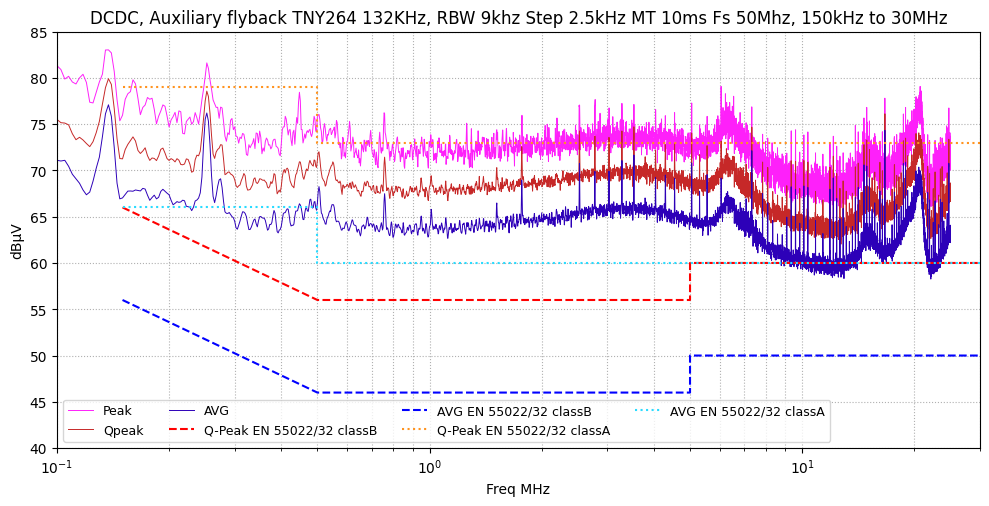

In [10]:
plt.figure(figsize=(10,5))
plt.semilogx(freqs*1e-6, peak, label='Peak', color='#FE20FA', linewidth=0.7)
plt.semilogx(freqs*1e-6, qp, label='Qpeak', color='#C62828', linewidth=0.7) 
plt.semilogx(freqs*1e-6, avg, label='AVG', color='#2D00B8', linewidth=0.7)


# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Q-Peak EN 55022/32 classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG EN 55022/32 classB', c= "b",linestyle="--")


# CISPR 22 / EN 55032 - CLASS A (Industrial) - Mains Port
# Note: Class A has a step at 500 kHz, not 5 MHz.
freqs0 = np.array([150e3, 500e3, 500e3, 30e6])
qp_limits = np.array([79.0, 79.0, 73.0, 73.0])   # dBµV
avg_limits = np.array([66.0, 66.0, 60.0, 60.0])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Q-Peak EN 55022/32 classA', c="#FF931F",linestyle=':')
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG EN 55022/32 classA', c= "#29DBFF",linestyle=':')

plt.ylim(40, 85)
plt.yticks(np.arange(40, 85+1, 5))
plt.grid(True)
plt.grid(True, which='both', ls=':')
plt.xlabel('Freq MHz')
plt.xlim([0.1, 30])
plt.ylabel('dBµV')
plt.legend(ncol=4, fontsize=9)
plt.tight_layout()
plt.title("DCDC, Auxiliary flyback TNY264 132KHz, RBW 9khz Step 2.5kHz MT 10ms Fs 50Mhz, 150kHz to 30MHz")
plt.savefig("DCDC_Flyback.png")
plt.show()